In [160]:
#!pip -q install wfdb
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal
from collections import Counter, OrderedDict

In [161]:
mit_dir=r'C:\Users\kramorov.s\Documents\arryth\mit'
file_with_files_to_read='RECORDS_GOOD'
label_desc= {'!':'Ventricular flatter wave', '+':'Rhytm change', 'A':'Atrial premature contraction', 'E':'Ventricular escape beat', 'F':'Fusion of vetricular and normal beat', 'L':'Left bundle branch block beat', 'N':'Normal beat', 'R':'Right bundle branch block beat', 'V':'Prematural ventricular contraction', 'a':'Aberrated atrial premature beat', 'j':'Nodal (junctional) escape beat', 'x':'Non-conducted P-wave (blocked APB)','~':'Signal quality change'}
allowed_labels=list(label_desc.keys())

In [206]:
class Pan_Tompkins_QRS():
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds.

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''

    # Initialize result
    result = None

    # Create a copy of the input signal
    sig = signal.copy()

    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
      sig[index] = signal[index]

      if (index >= 1):
        sig[index] += 2*sig[index-1]

      if (index >= 2):
        sig[index] -= sig[index-2]

      if (index >= 6):
        sig[index] -= 2*signal[index-6]

      if (index >= 12):
        sig[index] += signal[index-12]

    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
      result[index] = -1*sig[index]

      if (index >= 1):
        result[index] -= result[index-1]

      if (index >= 16):
        result[index] += 32*sig[index-16]

      if (index >= 32):
        result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-min(result))
    result = result/max_val

    return result

  def derivative(self,signal):
    '''
    Derivative Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The derivative of the input signal is taken to obtain the
    information of the slope of the signal. Thus, the rate of change
    of input is obtain in this step of the algorithm.

    The derivative filter has the recursive equation:
      y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    '''

    # Initialize result
    result = signal.copy()

    # Apply the derivative filter using the equation given
    for index in range(len(signal)):
      result[index] = 0

      if (index >= 1):
        result[index] -= 2*signal[index-1]

      if (index >= 2):
        result[index] -= signal[index-2]

      if (index >= 2 and index <= len(signal)-2):
        result[index] += 2*signal[index+1]

      if (index >= 2 and index <= len(signal)-3):
        result[index] += signal[index+2]

      result[index] = (result[index]*annotation.fs)/8

    return result

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The squaring process is used to intensify the slope of the
    frequency response curve obtained in the derivative step. This
    step helps in restricting false positives which may be caused
    by T waves in the input signal.

    The squaring filter has the recursive equation:
      y(nT) = [x(nT)]^2
    '''

    # Initialize result
    result = signal.copy()

    # Apply the squaring using the equation given
    for index in range(len(signal)):
      result[index] = signal[index]**2

    return result

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * annotation.fs)
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
      sum += signal[j]/win_size
      result[j] = sum

    # Apply the moving window integration using the equation given
    for index in range(win_size,len(signal)):
      sum += signal[index]/win_size
      sum -= signal[index-win_size]/win_size
      result[index] = sum

    return result

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned.
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()
    #input_signal=signal[:,1].copy()
    # Bandpass Filter
    bpass = self.band_pass_filter(input_signal.copy())

    # Derivative Function
    #der = self.derivative(bpass.copy())

    # Squaring Function
    #sqr = self.squaring(der.copy())

    # Moving Window Integration Function
    #mwin = self.moving_window_integration(sqr.copy())

    return input_signal, bpass #,der,sqr,  mwin

In [179]:
signal_number=9
filename = f'{mit_dir}\{str(100 + signal_number)}'
record = wfdb.rdrecord(filename, sampfrom=180, sampto=4000,)
annotation = wfdb.rdann(filename, 'atr', sampfrom=180, sampto=4000,shift_samps=True)
#wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))

In [181]:
record.p_signal.shape

(3820, 2)

In [7]:
records_filename = f'{mit_dir}\{file_with_files_to_read}'
with open(records_filename) as f:
    records_to_read = f.read().split('\n')
records_to_read_list=records_to_read[:len(records_to_read)-1]

In [207]:
headers=list()
annotations=list()
all_annotations_symbols=list()
records=list()
input_signals=list()
input_signals1=list()
bpass_signals=list()
bpass_signals1=list()
# derivated_signals=list()
# squared_signals=list()
# moving_window_signals=list()
counter=0
QRS_detector = Pan_Tompkins_QRS()
for fname in records_to_read_list:
    filename=f'{mit_dir}\{fname}'
    print(f'Обрабатывается файл "{fname}", файл #{counter+1} из {len(records_to_read_list)}')
    #hdr=wfdb.io.rdheader(filename, rd_segments=False)
    #headers.append(hdr)
    #record = wfdb.rdrecord(filename, sampfrom=180, sampto=4000,)
    record = wfdb.rdrecord(filename)

    ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
    input_signal, bpass  = QRS_detector.solve(ecg)
    input_signals.append(input_signal)
    bpass_signals.append(bpass)

    ecg1 = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,1]]).T,columns=['TimeStamp','ecg'])
    input_signal1, bpass1  = QRS_detector.solve(ecg1)
    input_signals1.append(input_signal1)
    bpass_signals1.append(bpass1)

    annotation = wfdb.rdann(filename, 'atr', shift_samps=True)
    annotations.append(annotation)
    '''all_annotations_symbols=all_annotations_symbols+[f'{annotation.symbol[i]}{annotation.subtype[i]}' for i in range(0, len(annotation.subtype))]'''
    #all_annotations_symbols=all_annotations_symbols+[f'{annotation.symbol[i]}' for i in range(0, len(annotation.symbol))]
    #print (f'record_name:{hdr.record_name}, fs={hdr.fs}, sig_len={hdr.sig_len}, sig_name={hdr.sig_name},\
    # baseline={hdr.baseline}, units={hdr.units} ')
    if counter==2:
        break;
    counter+=1
# wfdb.show_ann_labels()
print('Обработка завершена!')

Обрабатывается файл "101", файл #1 из 38
Обрабатывается файл "105", файл #2 из 38
Обрабатывается файл "106", файл #3 из 38
Обработка завершена!


In [204]:
record.adc()[:,1].shape

(650000,)

In [16]:
# Анализ количества различных эпизодов в выборке

#print(Counter(all_annotations_symbols).keys())
#print(Counter(all_annotations_symbols).values())
#count_dict = dict(Counter(all_annotations_symbols).items())
print(sorted(Counter(all_annotations_symbols).items()))
'''annotations[4].sample array([ 163,  391,  627,  868, 1107, 1343, 1585, 1814, 2039, 2255, 2481, 2703, 2936, 3172, 3406, 3633], dtype=int64),
annotations[4].symbol
subtype
chan
num
aux_note'''

In [210]:
def get_episodes(cur_annotation, input_signal, input_signal1, bpass, bpass1):
    episodes_input=list()
    episodes_input1=list()
    episodes_bpass=list()
    episodes_bpass1=list()
    episodes_labels=list()
    episodes_spike=list()
    bpass_offset=20
    max_episodes=len(cur_annotation.symbol)-2
    for i in range(2, max_episodes):
        if cur_annotation.symbol[i] in allowed_labels:
            spike_pos=cur_annotation.sample[i]
            previous_spike=cur_annotation.sample[i-1]
            next_spike=cur_annotation.sample[i+1]
            episode_start_pos=spike_pos-(spike_pos-previous_spike)//2
            episode_end_pos=spike_pos+(next_spike-spike_pos)//2
            episode_lenght=episode_end_pos-episode_start_pos
            #print(f'Эпизод {i} of {max_episodes}: Символ=_{cur_annotation.symbol[i]}_ длина эпизода:{episode_lenght}')
            episodes_input.append(input_signal[episode_start_pos:episode_end_pos])
            episodes_input1.append(input_signal1[episode_start_pos:episode_end_pos])
            episodes_bpass.append(bpass[episode_start_pos+bpass_offset:episode_end_pos+bpass_offset])
            episodes_bpass1.append(bpass1[episode_start_pos+bpass_offset:episode_end_pos+bpass_offset])
            episodes_spike.append(spike_pos-episode_start_pos)
            episodes_labels.append(cur_annotation.symbol[i])
        else:
            print(f'Пропускаем эпизод, символ=_{cur_annotation.symbol[i]}_')
    print(f'Загружены эпизоды: {sorted(Counter(episodes_labels).items())}')
    return episodes_input, episodes_input1, episodes_bpass, episodes_bpass1, episodes_spike, episodes_labels

In [211]:
# input_signal=input_signals[0][180:4000]
# bpass=bpass_signals[0][180:4000]
# der=derivated_signals[0][180:4000]
# sqr=squared_signals[0][180:4000]
# mwin=moving_window_signals[0][180:4000]
list_number=2
episodes_input, episodes_input1, episodes_bpass, episodes_bpass1, episodes_spike, episode_labels=get_episodes(annotations[list_number],input_signals[list_number], input_signals1[list_number],bpass_signals[list_number], bpass_signals1[list_number])

Загружены эпизоды: [('+', 40), ('N', 1506), ('V', 519), ('~', 29)]


In [166]:
def resample_fft(signal, desired_length):
    resampled_signal = scipy.signal.resample(signal, desired_length)
    return resampled_signal
def resample_poly(signal, desired_length):
    resampled_signal = scipy.signal.resample_poly(signal, desired_length, len(signal))
    return resampled_signal

In [168]:
win_index=[3,1200,len(episodes_spike)-20]
for i in range(0, len(win_index)):
    bpass= episodes_bpass[win_index[i]]
    inp=episodes_input[win_index[i]]
    print(f'For sample {win_index[i]} bpass.shape={bpass.shape}, input.shape={inp.shape}')
    bpass_fft=resample_fft(bpass, 512)
    inp_fft=resample_fft(inp, 512)
    print(f'Reshaped sample {win_index[i]} bpass_fft.shape={bpass_fft.shape}, inp_fft.shape={inp_fft.shape}')

For sample 3 bpass.shape=(371,), input.shape=(371,)
Reshaped sample 3 bpass_fft.shape=(512,), inp_fft.shape=(512,)
For sample 1200 bpass.shape=(300,), input.shape=(300,)
Reshaped sample 1200 bpass_fft.shape=(512,), inp_fft.shape=(512,)
For sample 2074 bpass.shape=(189,), input.shape=(189,)
Reshaped sample 2074 bpass_fft.shape=(512,), inp_fft.shape=(512,)


Text(0.5, 0.98, 'Образцы нарезанных кадров')

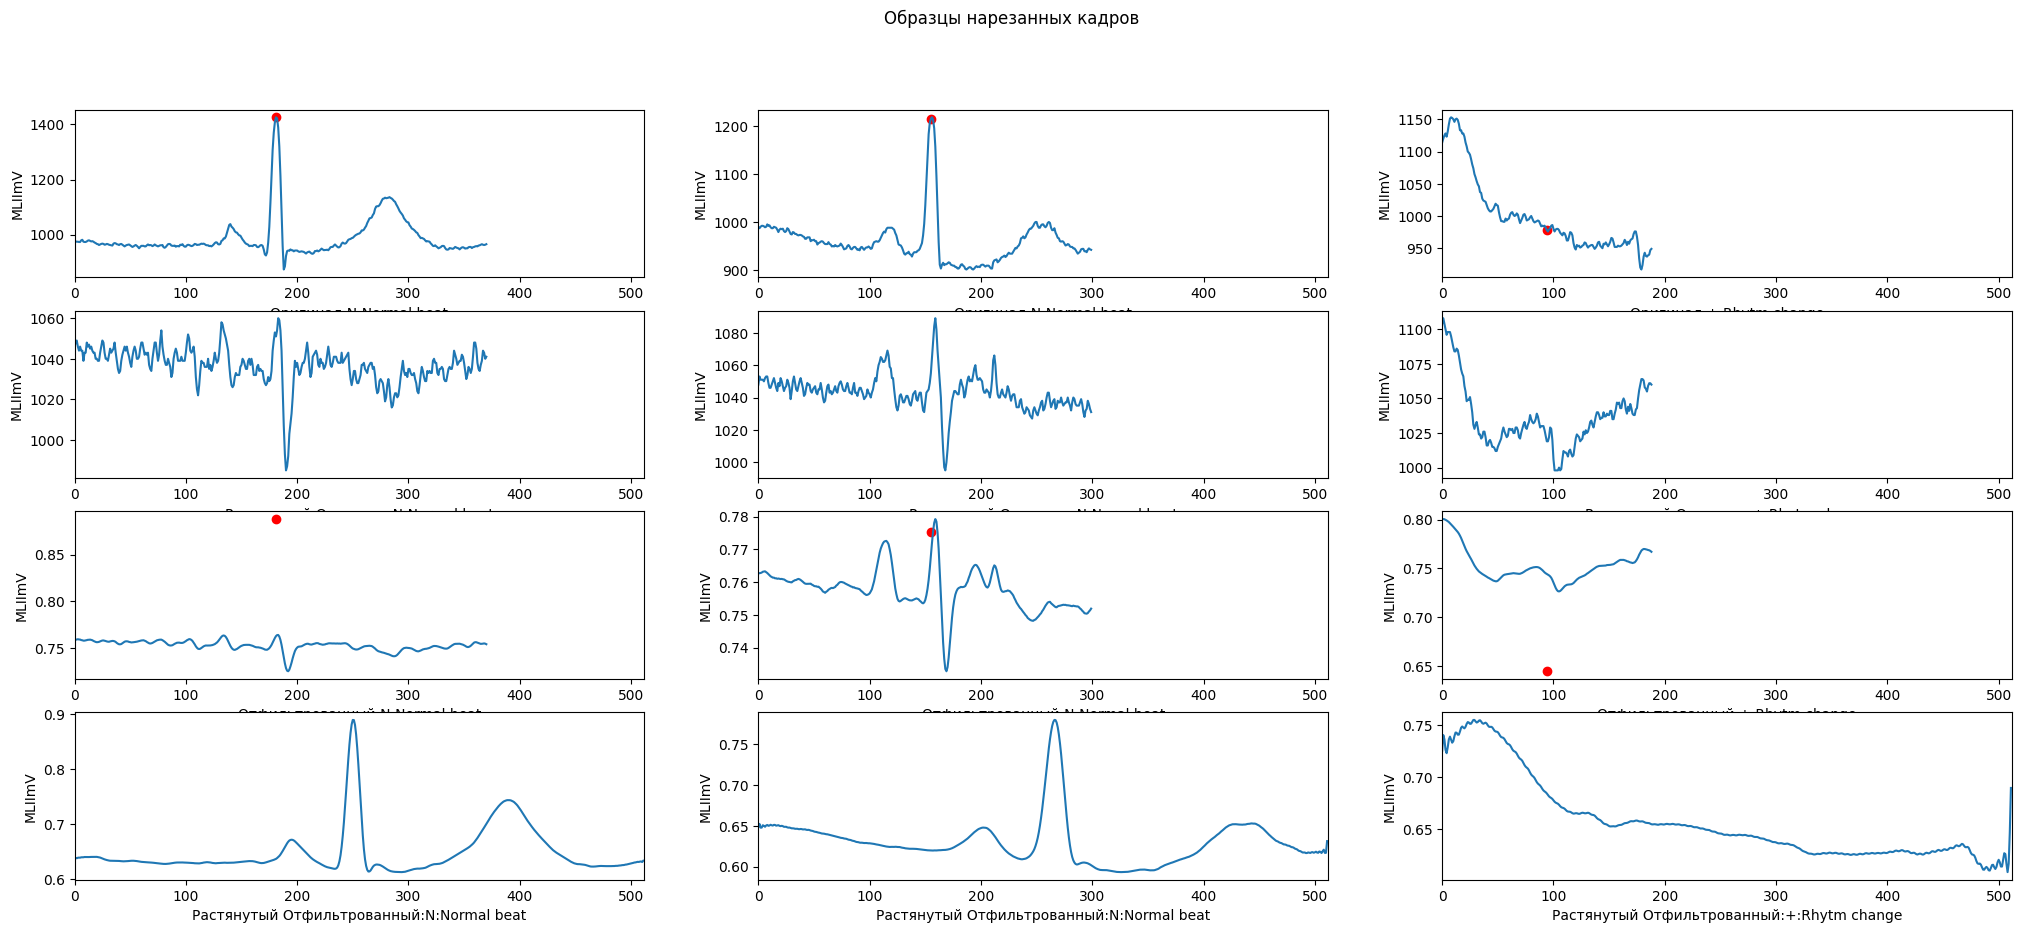

In [213]:
#win_index=[3, 20,117]
win_index=[3,1200,len(episodes_spike)-20]
fig, axs = plt.subplots(4, 3, figsize=(25, 10))
#plt.figure(figsize = (4,3), dpi = 100)
#plt.xticks(np.arange(start_pos, end_pos, 30))
for i in range(0, len(win_index)):
    axs[0,i].plot(episodes_input[win_index[i]])
    axs[0,i].set_xlim(0, 512)
    spike_x=episodes_spike[win_index[i]]
    spike_y=episodes_input[win_index[i]][episodes_spike[win_index[i]]]
    axs[0,i].scatter(spike_x, spike_y, marker='o', color='r', label='point')
    axs[0,i].set_xlabel(f'Оригинал:{episode_labels[win_index[i]]}:{label_desc.get(episode_labels[win_index[i]])}')
    axs[0,i].set_ylabel('MLIImV')

    axs[2,i].plot(episodes_bpass1[win_index[i]])
    axs[2,i].set_xlim(0, 512)
    spike_x=episodes_spike[win_index[i]]
    spike_y=episodes_bpass[win_index[i]][episodes_spike[win_index[i]]]
    axs[2,i].scatter(spike_x, spike_y, marker='o', color='r', label='point')
    axs[2,i].set_xlabel(f'Отфильтрованный:{episode_labels[win_index[i]]}:{label_desc.get(episode_labels[win_index[i]])}')
    axs[2,i].set_ylabel('MLIImV')

    inp=episodes_input[win_index[i]]
    inp1=episodes_input1[win_index[i]]
    bpass= episodes_bpass[win_index[i]]
    bpass_fft=resample_fft(bpass, 512)
    inp_fft=resample_fft(inp, 512)

    axs[1,i].plot(inp1)
    axs[1,i].set_xlim(0, 512)
    #spike_x=episodes_spike[win_index[i]]
    #spike_y=episodes_input[win_index[i]][episodes_spike[win_index[i]]]
    #axs[1,i].scatter(spike_x, spike_y, marker='o', color='r', label='point')
    axs[1,i].set_xlabel(f'Растянутый Оригинал:{episode_labels[win_index[i]]}:{label_desc.get(episode_labels[win_index[i]])}')
    axs[1,i].set_ylabel('MLIImV')

    axs[3,i].plot(bpass_fft)
    axs[3,i].set_xlim(0, 512)
    #spike_x=episodes_spike[win_index[i]]
    #spike_y=episodes_bpass[win_index[i]][episodes_spike[win_index[i]]]
    #axs[3,i].scatter(spike_x, spike_y, marker='o', color='r', label='point')
    axs[3,i].set_xlabel(f'Растянутый Отфильтрованный:{episode_labels[win_index[i]]}:{label_desc.get(episode_labels[win_index[i]])}')
    axs[3,i].set_ylabel('MLIImV')
    #print(f'episodes_input={len(episodes_input[win_index[i]])}, episodes_bpass={len(episodes_bpass[win_index[i]])} ')
fig.suptitle("Образцы нарезанных кадров")

Text(0.5, 1.0, 'Отфильтрованный сигнал')

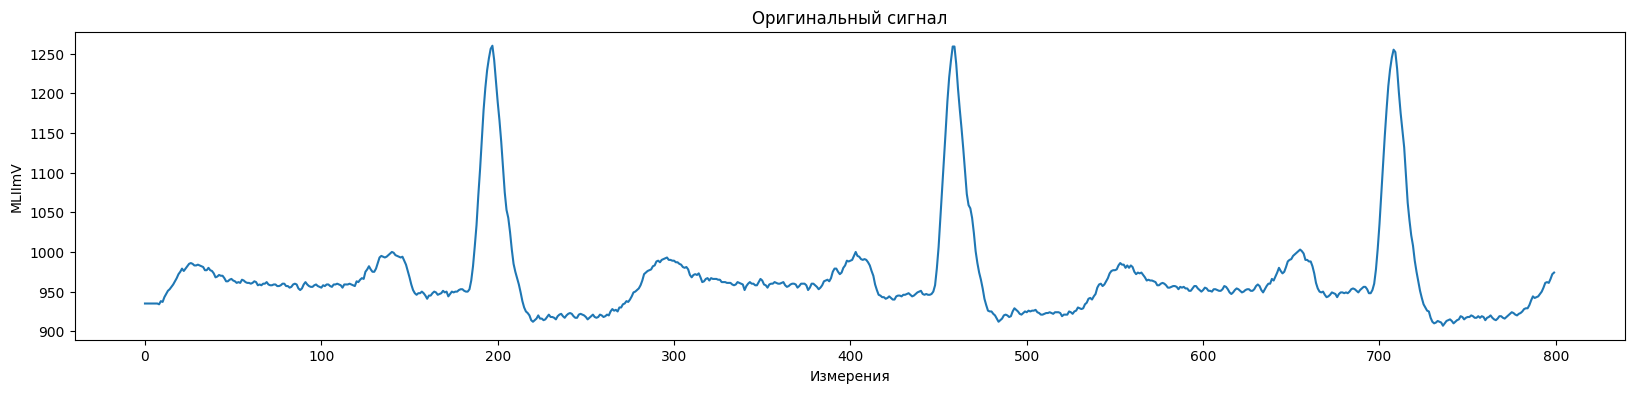

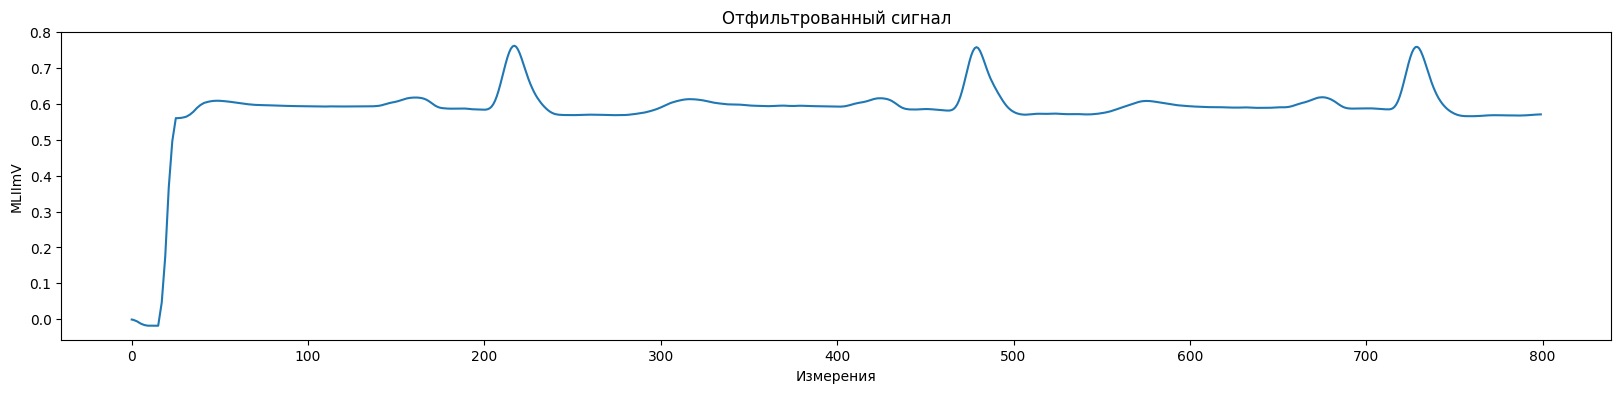

In [188]:
#    input_signals.append(input_signal)
#     bpass_signals.append(bpass)
# Выводим Оригинальный сигнал
plt.figure(figsize = (20,4), dpi = 100)
# plt.xticks(np.arange(0, len(input_signal)+1, 150))
plt.plot(input_signals0[1][0:800])
plt.xlabel('Измерения')
plt.ylabel('MLIImV')
plt.title("Оригинальный сигнал")


# Выводим Отфильтрованный сигнал
plt.figure(figsize = (20,4), dpi = 100)
# plt.xticks(np.arange(0, len(bpass)+1, 150))
plt.plot(bpass_signals[1][0:800])
plt.xlabel('Измерения')
plt.ylabel('MLIImV')
plt.title("Отфильтрованный сигнал")

In [19]:
len(records[4].adc())

650000

## Plotting the Signals

Text(0.5, 1.0, 'Интегральный сигнал в скользящем окне')

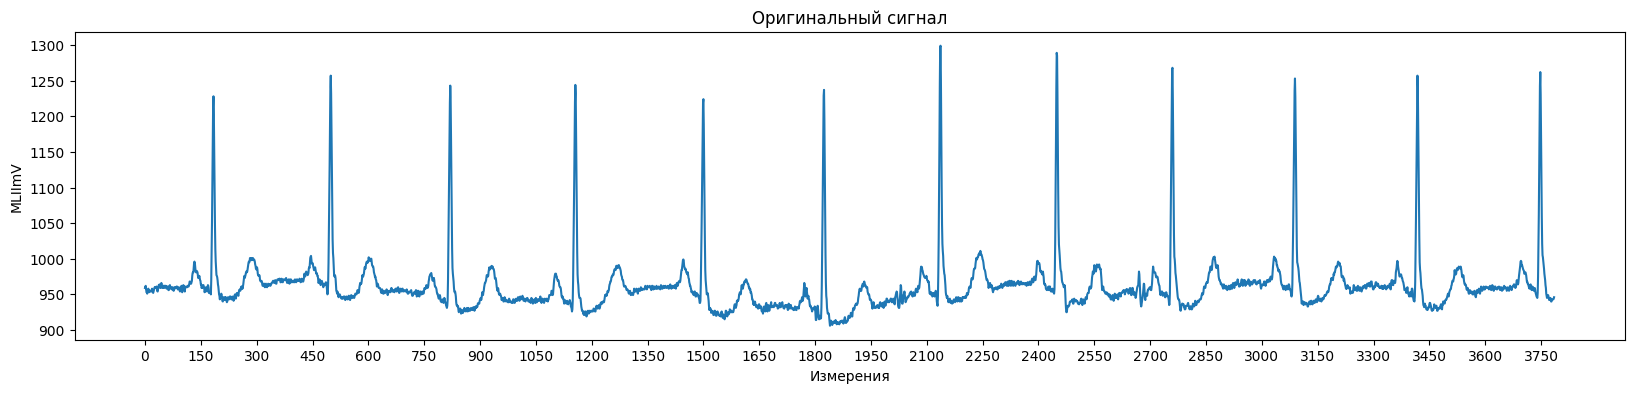

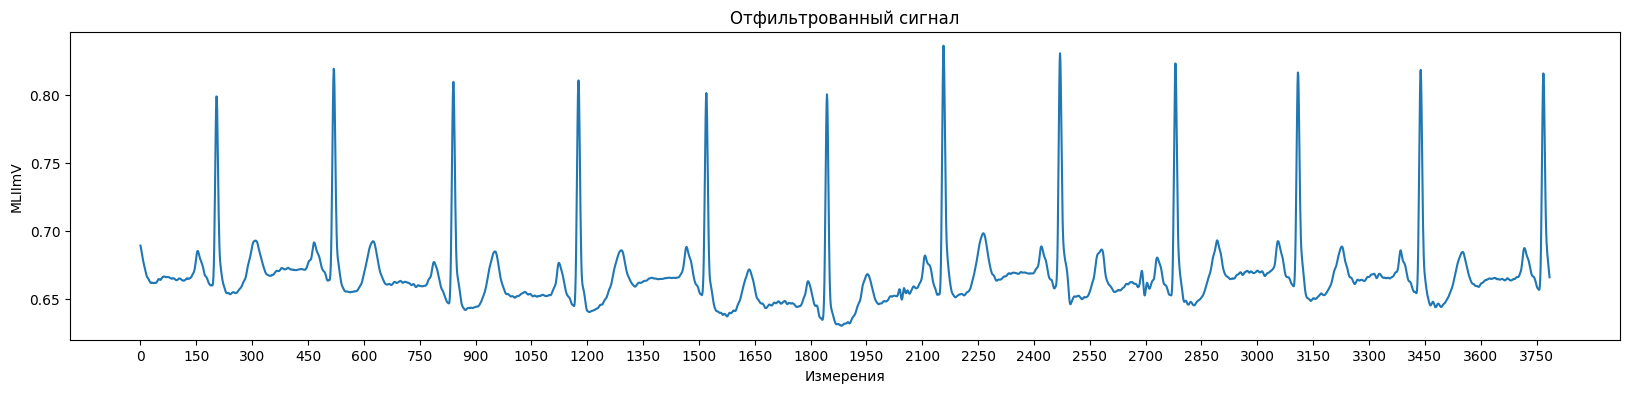

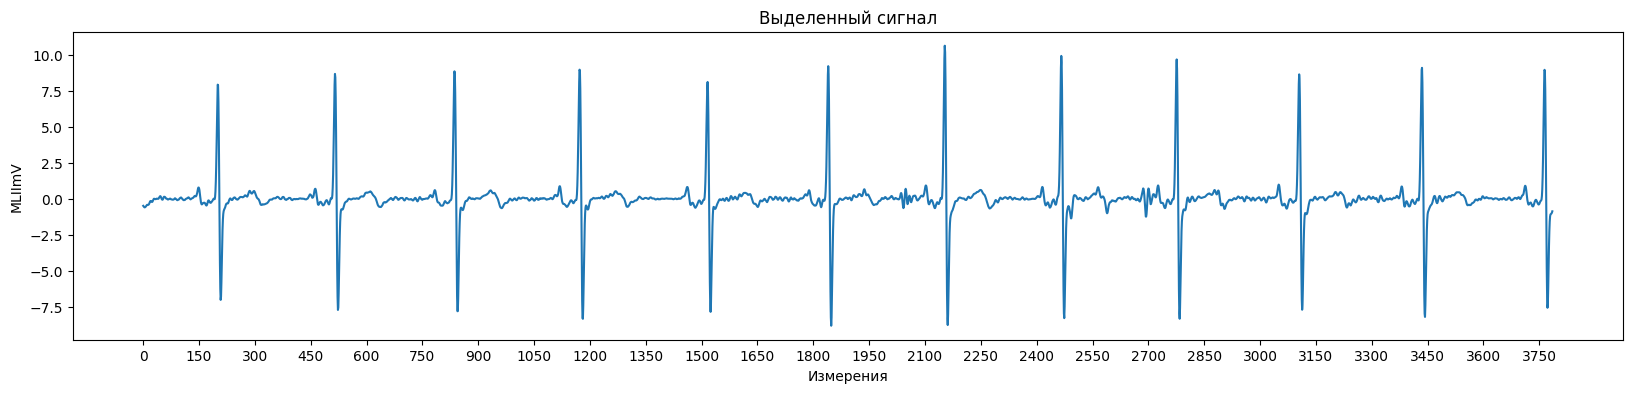

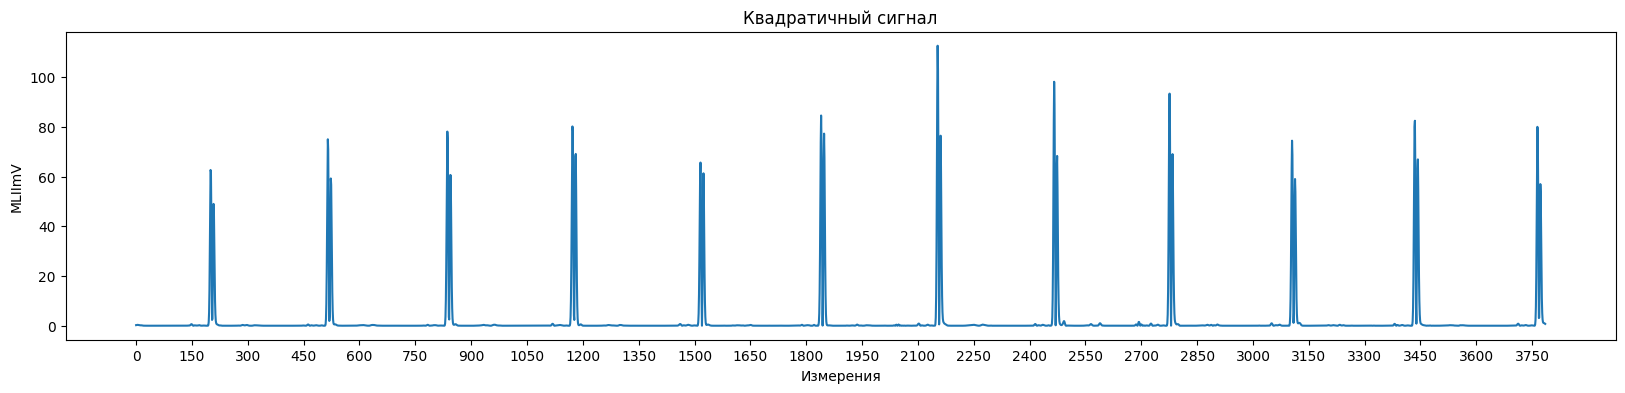

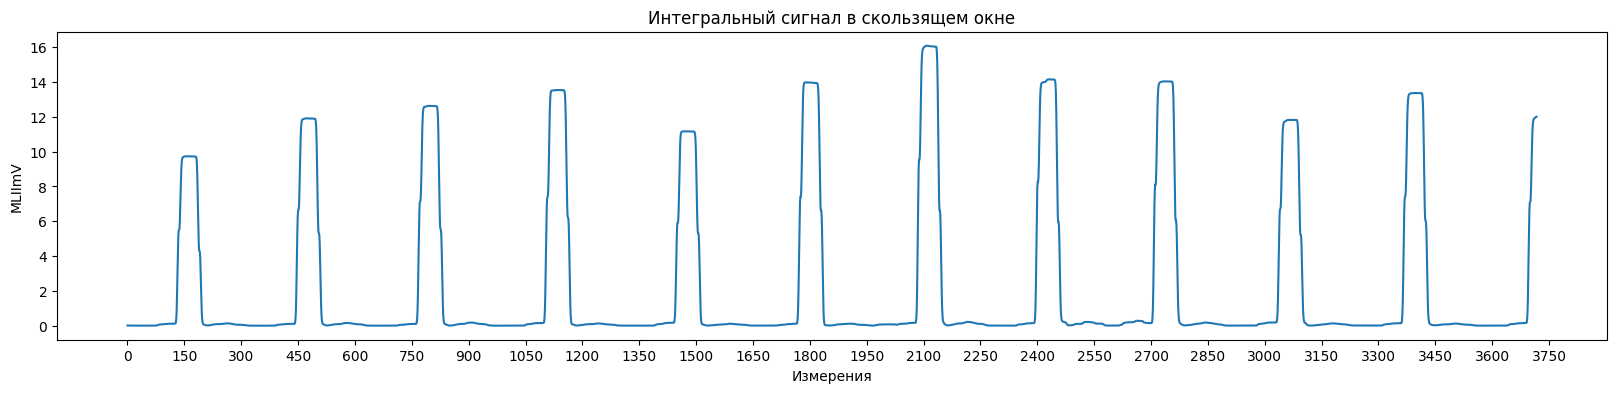

In [34]:
# Выводим Оригинальный сигнал
#wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))
input_signal=input_signals[0][180:4000]
bpass=bpass_signals[0][180:4000]
der=derivated_signals[0][180:4000]
sqr=squared_signals[0][180:4000]
mwin=moving_window_signals[0][180:4000]

# Выводим Оригинальный сигнал
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(input_signal)+1, 150))
plt.plot(input_signal[32:len(input_signal)-2])
plt.xlabel('Измерения')
plt.ylabel('MLIImV')
plt.title("Оригинальный сигнал")


# Выводим Отфильтрованный сигнал
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(bpass)+1, 150))
plt.plot(bpass[32:len(bpass)-2])
plt.xlabel('Измерения')
plt.ylabel('MLIImV')
plt.title("Отфильтрованный сигнал")

# Выводим Выделенный сигнал
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(der)+1, 150))
plt.plot(der[32:len(der)-2])
plt.xlabel('Измерения')
plt.ylabel('MLIImV')
plt.title("Выделенный сигнал")

# Выводим Квадратичный сигнал
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(sqr)+1, 150))
plt.plot(sqr[32:len(sqr)-2])
plt.xlabel('Измерения')
plt.ylabel('MLIImV')
plt.title("Квадратичный сигнал")

#  Выводим Интегральный сигнал в скользящем окне
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(mwin)+1, 150))
plt.plot(mwin[100:len(mwin)-2])
plt.xlabel('Измерения')
plt.ylabel('MLIImV')
plt.title("Интегральный сигнал в скользящем окне")